In [1]:
import random 
import math
import numpy as np
import pyvista as pv  # PyVista (3D可視化)
import pandas as pd
import copy
import homcloud.interface as hc
import matplotlib.pyplot as plt
pv.start_xvfb()

## 解析用のデータ作成

In [2]:
def tsutsu(n):
    for i in range(n):
        theta = 2.0 * math.pi * random.random()
        radius = math.sqrt(random.uniform(0.25,1.0))
        p = [[radius * math.cos(theta), radius * math.sin(theta), np.random.rand()]]
        if i == 0:
            data = p
        else:
            data = np.append(data, p, axis=0)
    return data

In [3]:
def randomincircle(n):
    for i in range(n):
        theta = 2.0 * math.pi * random.random()
        radius = math.sqrt(random.uniform(0.25,1.0))
        p = [[radius * math.cos(theta), radius * math.sin(theta)]]
        if i == 0:
            data = p
        else:
            data = np.append(data, p, axis=0)
    return data

In [4]:
def pinched_circle(n):
    for i in range(n):
        theta = 1.8 * math.pi * random.random()
        radius = math.sqrt(random.uniform(0.5,1.0))
        p = [[-radius * math.cos(theta), -radius * math.sin(theta)]]
        if i == 0:
            data = p
        else:
            if i <= n*0.8:
                data = np.append(data, p, axis=0)
            else:
                theta_s = 1.25*math.pi * random.random()
                radius_s = 0.5 * math.sqrt(random.uniform(0.25,1.0))
                x = radius_s * math.cos(theta_s)
                y = radius_s * math.sin(theta_s)
                p = [[-0.85+0.5*x - 0.86*y, 0.3 + 0.86*x +0.5*y]]
                data = np.append(data, p, axis=0)
    return data

In [7]:
# データファイルを扱いやすいように成形する関数

def get_pairs(DataFrame):
    df = copy.deepcopy(DataFrame)
    pairs = []
    pair = []
    paths = []
    for i in range(len(df)):
        s = df.iloc[i, 0]
    
        if s[0] == ';':
            l = [pair, paths]
            pairs.append(l)
            pair = []
            paths = []
            l = []
            f = ''
            for j in range(len(s)-2):
                if not s[j+2] == '  ':
                    f += s[j+2]
            g = f.split()
            pair.append(float(g[0]))
            pair.append(float(g[1]))

        else:
            path = []
            if s == '1':
                path.append(df.iloc[i, 1])
                path.append(df.iloc[i, 2])
            elif s == '-1':
                path.append(df.iloc[i, 2])
                path.append(df.iloc[i, 1])
            paths.append(path)

    l = [pair, paths]
    pairs.append(l)
    pairs.pop(0)

    return pairs

In [8]:
# 頂点をインデックス表示から座標に変換する関数

def get_pairs_coordinate(pairs, points):
    c_pairs = copy.deepcopy(pairs)
    d = points
    for i in range(len(c_pairs)):
        for j in range(len(c_pairs[i][1])):
            p = c_pairs[i][1][j]
            for k in range(2):
                for l in range(len(d)):
                    if p[k] == d[l][0]:
                        p[k] = [d[l][1], d[l][2], d[l][3]]
                        break
    return c_pairs

In [9]:
# 特定の区間(b, d)の最適サイクルを返す関数

def nearest_pair(pairs, b):
    b_n = pairs[0][0][0]
    d_n = pairs[0][0][1]
    for i in range(len(pairs)-1):
        if math.fabs(b - b_n) > math.fabs(b - pairs[i][0][0]):
            b_n = pairs[i][0][0]
            d_n = pairs[i][0][1]
            pair = pairs[i][1]
    return (b_n, d_n, pair)

In [10]:
def make_image_optiperlp(pair, op_i2p, op_1):
    points = np.loadtxt(op_i2p)
    df = pd.read_csv(op_1, names=('birth/death', 'v0', 'v1'))
    pairs = get_pairs(df)
    c_pairs = get_pairs_coordinate(pairs, points)
    
    # optiperlpの特定のペアのpathの部分だけの情報を取得する
    line = nearest_pair(c_pairs, pair.birth)[2]
    mesh = pv.Line(line[0][0], line[0][1])
    for i in range(len(line)-1):
        mesh += pv.Line(line[i+1][0], line[i+1][1])
    return mesh

In [15]:
def load(txt):
    points = np.loadtxt(txt)
    return points

In [29]:
data_tsutsu = load('data_tsutsu.txt')
data_maru = load('data_maru.txt')
data_pmaru = load('data_pinched_maru.txt')

## 可視化と解析_tsutsu

In [30]:
hc.PDList.from_alpha_filtration(data_tsutsu, save_boundary_map=True, save_to="pointcloud-tsutsu.pdgm")

PDList(path=pointcloud-tsutsu.pdgm)

In [31]:
pdlist_tsutsu = hc.PDList("pointcloud-tsutsu.pdgm")
pd1_tsutsu = pdlist_tsutsu.dth_diagram(1)

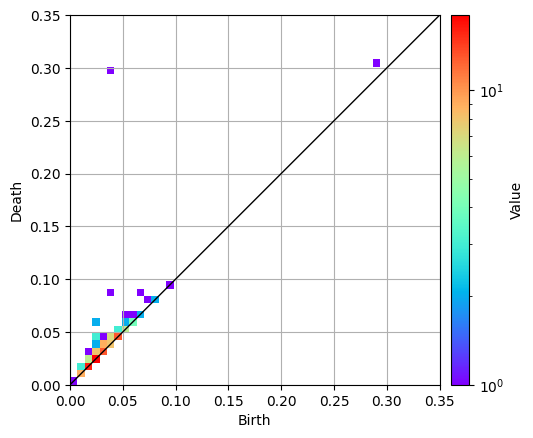

In [34]:
pd1_tsutsu.histogram((0,0.35),50).plot(colorbar={"type": "log"})
#plt.savefig("pointcloud_pd1_tsutsu.png")

In [35]:
pair_tsutsu = pd1_tsutsu.nearest_pair_to(0.04, 0.30)
pair_tsutsu

Pair(0.03812050528171212, 0.2969209900187512)

In [27]:
pair_tsutsu.birth

0.03812050528171212

In [36]:
def make_image(pair):
    lifetime = pair.lifetime()
    lifetime_1_10 = lifetime/10
    lifetime_1_50 = lifetime/50
    lifetime_1_100 = lifetime/100
    stable_volume_1_10 = pair.stable_volume(lifetime_1_10)
    stable_volume_1_50 = pair.stable_volume(lifetime_1_50)
    stable_volume_1_100 = pair.stable_volume(lifetime_1_100)
    optimal_volume = pair.optimal_volume()
    return stable_volume_1_10.to_pyvista_boundary_mesh(), stable_volume_1_50.to_pyvista_boundary_mesh(), stable_volume_1_100.to_pyvista_boundary_mesh(), optimal_volume.to_pyvista_boundary_mesh()

In [37]:
mesh_sv_1_10_tsutsu, mesh_sv_1_50_tsutsu, mesh_sv_1_100_tsutsu, mesh_ov_tsustu = make_image(pair_tsutsu)

In [40]:
mesh_op_tsutsu = make_image_optiperlp(pair_tsutsu, 'gen_data_tsutsu_op_i2p.txt', 'gen_data_tsutsu_op_1.txt')

In [44]:
data_tsutsu = p

pl_t = pv.Plotter()

pl_t.add_mesh(pv.PointSet(data_tsutsu), point_size=2)
pl_t.add_mesh(mesh_op_tsutsu, color="skyblue", line_width=5)
pl_t.add_mesh(mesh_ov_tsustu, color="yellow", line_width=2)
pl_t.add_mesh(mesh_sv_1_10_tsutsu, color="blue", line_width=2)
#pl_t.add_mesh(mesh_sv_1_50_tsutsu, color="red", line_width=2)
#pl_t.add_mesh(mesh_sv_1_100_tsutsu, color="white", line_width=2)

pl_t.show()

Widget(value="<iframe src='http://localhost:38001/index.html?ui=P_0x7f07972afeb0_5&reconnect=auto' style='widt…

## 可視化と解析_maru

In [45]:
hc.PDList.from_alpha_filtration(data_maru, save_boundary_map=True, save_to="pointcloud-maru.pdgm")

PDList(path=pointcloud-maru.pdgm)

In [46]:
pdlist_maru = hc.PDList("pointcloud-maru.pdgm")
pd1_maru = pdlist_maru.dth_diagram(1)

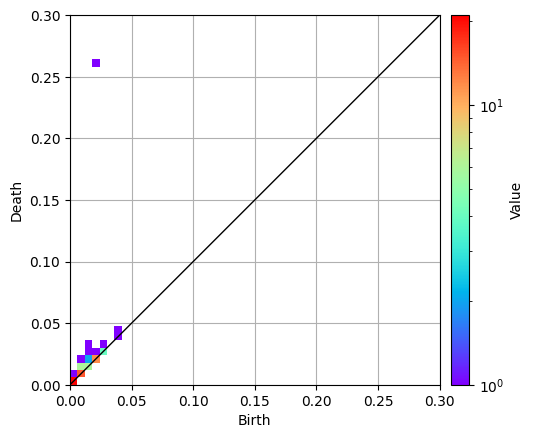

In [47]:
pd1_maru.histogram((0,0.3),50).plot(colorbar={"type": "log"})
plt.savefig("pointcloud_pd1_maru.png")

In [48]:
pair_maru = pd1_maru.nearest_pair_to(0.025, 0.26)
pair_maru

Pair(0.019498285317257988, 0.2599659778826891)

In [49]:
mesh_sv_1_10_maru, mesh_sv_1_50_maru, mesh_sv_1_100_maru, mesh_ov_maru = make_image(pair_maru)

In [50]:
mesh_op_maru = make_image_optiperlp(pair_maru, 'gen_data_maru_op_i2p.txt', 'gen_data_maru_op_1.txt')

In [51]:
pl_m = pv.Plotter()

pl_m.add_mesh(pv.PointSet(data_maru), point_size=5)
pl_m.add_mesh(mesh_op_maru, color="skyblue", line_width=2)
pl_m.add_mesh(mesh_ov_maru, color="yellow", line_width=3)
#pl_m.add_mesh(mesh_sv_1_10_maru, color="blue", line_width=2)
#pl_m.add_mesh(mesh_sv_1_50_maru, color="red", line_width=4)
#pl_m.add_mesh(mesh_sv_1_100_maru, color="white", line_width=2)

pl_m.show()

Widget(value="<iframe src='http://localhost:38001/index.html?ui=P_0x7f07973658a0_6&reconnect=auto' style='widt…

## 可視化と解析_pmaru

In [52]:
hc.PDList.from_alpha_filtration(data_pmaru, save_boundary_map=True, save_to="pointcloud-pinched_maru.pdgm")

PDList(path=pointcloud-pinched_maru.pdgm)

In [53]:
pdlist_pmaru = hc.PDList("pointcloud-pinched_maru.pdgm")
pd1_pmaru = pdlist_pmaru.dth_diagram(1)

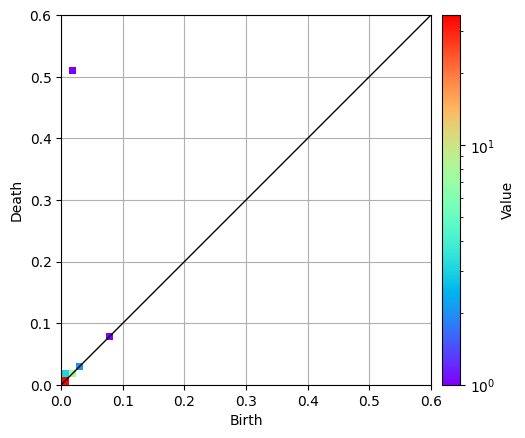

In [54]:
pd1_pmaru.histogram((0,0.6),50).plot(colorbar={"type": "log"})
plt.savefig("pointcloud_pd1_pinched_maru.png")

In [55]:
pair_pmaru = pd1_pmaru.nearest_pair_to(0.025, 0.5)
pair_pmaru

Pair(0.019706067106302724, 0.5140882590743279)

In [56]:
mesh_sv_1_10_pmaru, mesh_sv_1_50_pmaru, mesh_sv_1_100_pmaru, mesh_ov_pmaru = make_image(pair_pmaru)

In [57]:
mesh_op_pmaru = make_image_optiperlp(pair_pmaru, 'gen_data_pinched_maru_op_i2p.txt', 'gen_data_pinched_maru_op_1.txt')

In [58]:
pl_p = pv.Plotter()

pl_p.add_mesh(pv.PointSet(data_pmaru), point_size=5)
pl_p.add_mesh(mesh_op_pmaru, color="skyblue", line_width=2)
pl_p.add_mesh(mesh_ov_pmaru, color="yellow", line_width=3)
pl_p.add_mesh(mesh_sv_1_10_pmaru, color="blue", line_width=2)
pl_p.add_mesh(mesh_sv_1_50_pmaru, color="red", line_width=4)
pl_p.add_mesh(mesh_sv_1_100_pmaru, color="white", line_width=2)

pl_p.show()

Widget(value="<iframe src='http://localhost:38001/index.html?ui=P_0x7f07974ad870_7&reconnect=auto' style='widt…